In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation
from keras.optimizers import Adam, SGD, Adagrad
from keras.initializers import glorot_uniform
import seaborn as sns

from matplotlib.pyplot import imshow

# HYPER-PARAMETERS

In [2]:
TEST_SIZE = 0.2

# Optimization

In [3]:
def reduce_mem_usage(df : pd.DataFrame):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if str(col_type)[:5] == 'float':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.finfo('f2').min and c_max < np.finfo('f2').max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo('f4').min and c_max < np.finfo('f4').max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
        elif str(col_type)[:3] == 'int':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo('i1').min and c_max < np.iinfo('i1').max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo('i2').min and c_max < np.iinfo('i2').max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo('i4').min and c_max < np.iinfo('i4').max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo('i8').min and c_max < np.iinfo('i8').max:
                df[col] = df[col].astype(np.int64)
        elif str(col_type)[:8] == 'datetime':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Потребление памяти меньше на',
         round(start_mem - end_mem, 2),
         'Мб (минус',
         round(100 * (start_mem - end_mem) / start_mem, 1),
         '%)')
    return df

# Data extract

In [4]:
methods = {
    "SHG Intensity" : [
        "SHG Intensity Mean",
        "SHG Intensity MAD",
        "SHG Intensity Contrast",
        "SHG Intensity Correlation",
        "SHG Intensity Entropy",
        "SHG Intensity ASM",
        "SHG Intensity IDM"
    ],
    "R-Ratio" : [
        "R-Ratio Mean",
        "R-Ratio MAD",
        "R-Ratio Contrast",
        "R-Ratio Correlation",
        "R-Ratio Entropy",
        "R-Ratio ASM"
    ],
    "Degree of Circular Polarization" : [
        "Degree of Circular Polarization Mean",
        "Degree of Circular Polarization MAD",
        "Degree of Circular Polarization Contrast",
        "Degree of Circular Polarization Correlation",
        "Degree of Circular Polarization Entropy",
        "Degree of Circular Polarization ASM",
        "Degree of Circular Polarization IDM"
    ],
    "SHG-CD" : [ 
        "SHG-CD MAD",
        "SHG-CD Contrast",
        "SHG-CD Correlation",
        "SHG-CD Entropy",
        "SHG-CD ASM",
        "SHG-CD IDM"
    ],
    "SHG-LD" : [
        "SHG-LD MAD",
        "SHG-LD Contrast",
        "SHG-LD Correlation",
        "SHG-LD Entropy",
        "SHG-LD ASM",
        "SHG-LD IDM"
    ]
}

x_axis = sum([methods[key] for key in methods.keys()], [])
# x_axis += "Pixel Density"

y_axis = "2-Group Tag"

def getData(table_number):
    data = pd.read_excel(io="../../Data/41598_2022_13623_MOESM3_ESM.xlsx", 
    sheet_name=f"{1 << 2 * (table_number - 1)} Subimage Training")
    data = reduce_mem_usage(data)
    data = (data - data.min()) / (data.max() - data.min())
    #data["2-Group Tag"] = data[y_axis] == 2
    return data


# Init data

In [5]:
data = getData(3)

# for i in range(4, 6):
#     data = pd.concat([data, getData(i)], ignore_index=True)

data_true = data[data[y_axis] == 1]
data_false = data[data[y_axis] == 0]

data['weights'] = data[y_axis].map({1: 100 * len(data_false) // len(data), 0: 100 * len(data_true) // len(data)})

train_data = data.sample(frac=1-TEST_SIZE, random_state=0, weights='weights')
test_data = data.drop(train_data.index)
X_train, X_test = train_data[x_axis].to_numpy(), test_data[x_axis].to_numpy()
y_train, y_test = train_data[y_axis].to_numpy(), test_data[y_axis].to_numpy()

X_train_data_true = X_train[y_train == 1]
X_train_data_false = X_train[y_train == 0]
print(len(X_train_data_false), len(X_train_data_true))

weights = [len(X_train_data_true) / len(X_train), len(X_train_data_false) / len(X_train)]
print("Weights:", weights)

n_samples, n_features, batch_size = *X_train.shape, 128

Потребление памяти меньше на 0.07 Мб (минус 74.5 %)
143 139
Weights: [0.4929078014184397, 0.5070921985815603]


In [6]:
data['weights'], data[y_axis]

(0      50
 1      50
 2      50
 3      50
 4      50
        ..
 347    49
 348    49
 349    49
 350    49
 351    49
 Name: weights, Length: 352, dtype: int64,
 0      0.0
 1      0.0
 2      0.0
 3      0.0
 4      0.0
       ... 
 347    1.0
 348    1.0
 349    1.0
 350    1.0
 351    1.0
 Name: 2-Group Tag, Length: 352, dtype: float64)

In [7]:
#model = Sequential()
# model.add(Input(shape=(32,)))
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(.8, input_shape=(8,)))
# model.add(Dense(4, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy',tf.keras.metrics.TruePositives()], loss_weights=weights[::-1]) # 
def getModel(dropout=0.00, neurons_first=500, neurons_second=250, learningRate=0.1):
    model = Sequential()
    model.add(Dense(neurons_first, activation='relu', input_dim=n_features, 
                    kernel_initializer=glorot_uniform(),
                    name='Dense_first'))
    model.add(Dense(neurons_first, activation='relu', input_dim=n_features, 
                kernel_initializer=glorot_uniform(),
                name='Dense_first1'))
    model.add(Dropout(dropout, name='Dropout_null'))
    model.add(Dense(neurons_first, activation='relu', input_dim=n_features, 
                kernel_initializer=glorot_uniform(),
                name='Dense_first2'))
    model.add(Dense(neurons_first, activation='relu', input_dim=n_features, 
                kernel_initializer=glorot_uniform(),
                name='Dense_first3'))
    model.add(Dropout(dropout, name='Dropout_first'))
    model.add(Dense(neurons_second, activation='relu', kernel_initializer=glorot_uniform(),
                    name='Dense_second'))
    model.add(Dropout(dropout, name='Dropout_second'))
    model.add(Dense(1, activation='sigmoid',
                    kernel_initializer=glorot_uniform(),
                    name='Result'))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adagrad(learning_rate=learningRate), metrics=['accuracy'], loss_weights=weights[::-1])
    return model


In [8]:
increasedDropout = 0.5
increasedNeurons1 = 1000
model = getModel(increasedDropout, neurons_first=increasedNeurons1)
net = model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
3/3 [==============================] - 1s 166ms/step - loss: 0.3533 - accuracy: 0.5035 - val_loss: 0.3479 - val_accuracy: 0.4286
Epoch 2/50
3/3 [==============================] - 0s 34ms/step - loss: 0.3448 - accuracy: 0.5674 - val_loss: 0.3491 - val_accuracy: 0.4286
Epoch 3/50
3/3 [==============================] - 0s 32ms/step - loss: 0.3456 - accuracy: 0.5071 - val_loss: 0.3367 - val_accuracy: 0.4286
Epoch 4/50
3/3 [==============================] - 0s 32ms/step - loss: 0.3375 - accuracy: 0.5957 - val_loss: 0.3220 - val_accuracy: 0.8571
Epoch 5/50
3/3 [==============================] - 0s 33ms/step - loss: 0.3278 - accuracy: 0.7163 - val_loss: 0.3147 - val_accuracy: 0.5714
Epoch 6/50
3/3 [==============================] - 0s 32ms/step - loss: 0.3205 - accuracy: 0.6702 - val_loss: 0.2926 - val_accuracy: 0.7571
Epoch 7/50
3/3 [==============================] - 0s 34ms/step - loss: 0.3073 - accuracy: 0.7340 - val_loss: 0.2592 - val_accuracy: 0.9000
Epoch 8/50
3/3 [==========

In [9]:
y_predict = model.predict(data[x_axis])
confusion_matrix = tf.math.confusion_matrix(data[y_axis], np.round(y_predict))

11/11 [==============================] - 0s 3ms/step


In [10]:
print(confusion_matrix)

tf.Tensor(
[[155  18]
 [  1 178]], shape=(2, 2), dtype=int32)


In [11]:
# data[y_axis] = data[y_axis].astype('object')
# sns.pairplot(data, hue=y_axis, vars=methods["SHG Intensity"])

In [16]:
data_for_predict = pd.read_excel("../../Data/mydata4096.xlsx")
data_for_predict = reduce_mem_usage(data_for_predict)
X_for_predict = data_for_predict[x_axis]

Потребление памяти меньше на 0.8 Мб (минус 75.0 %)


In [19]:
y_pred = np.round(model.predict(X_for_predict))
print(y_pred)
y_pred = y_pred.reshape(64, 64)

128/128 [==============================] - 1s 4ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


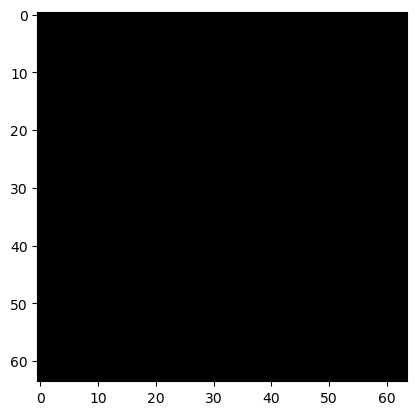

In [20]:
y_pred *= 255
y_pred = y_pred.astype(np.int16)
imshow(y_pred, cmap='gray', vmin=0, vmax=255)

In [15]:
print(y_pred[y_pred != 0])

[]
